 <div style="text-align: right">   </div>
 Introduction to Deep Learning (2024)

 **Assignment 2 - Sequence processing using RNNs**
 <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">

 # Introduction

 The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs).
 Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

 <img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

 In this assignment you will be working with three different kinds of models, based on input/output data modalities:

 1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation

 2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.

 3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.

 ### Description

 Let us suppose that we want to develop a neural network that learns how to add or subtract

 two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or

 ’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a

 sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,

 we want to build a model that generalizes well - if the network can extract the underlying principles behind

 the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate

 valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),

 2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.

 The example above describes a text-to-text sequence mapping scenario. However, we can also use different

 modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit

 dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

 *To work on this notebook you should create a copy of it.*


 # Function definitions for creating the datasets

 First we need to create our datasets that are going to be used for training our models.

 In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library.
 We will use these operand signs together with the MNIST dataset to represent the digits.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, LSTM, Flatten, TimeDistributed # type: ignore
from tensorflow.keras.layers import RepeatVector, Conv2D, ConvLSTM2D # type: ignore

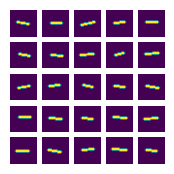

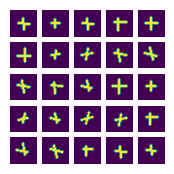

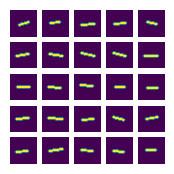

In [ ]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images


def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))
show_generated(generate_images(sign='-'))

In [ ]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:
    
    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []

                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())
                    
                X_text.append(query_string)
                X_img.append(np.stack(query_image))

                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '

    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)

 # Creating our data

 The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

   **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]
   **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

   **y_text**: strings containing answers of length 3: ['  2', '156']
   **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #5187

X_text: "25-93" = y_text: "-68"


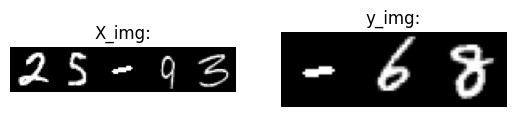

Query #4655

X_text: "23-27" = y_text: "-4 "


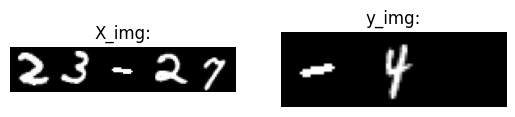

Query #6779

X_text: "33-89" = y_text: "-56"


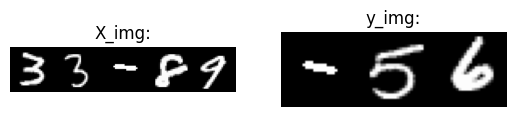

Query #517

X_text: "2-58 " = y_text: "-56"


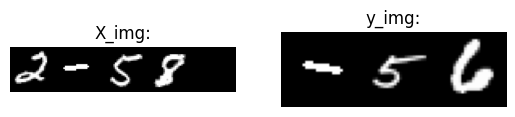

Query #5757

X_text: "28-78" = y_text: "-50"


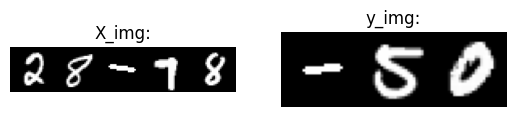

Query #351

X_text: "1-75 " = y_text: "-74"


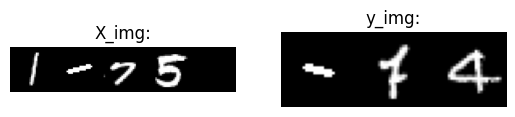

Query #1371

X_text: "6-85 " = y_text: "-79"


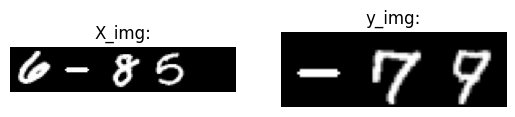

Query #2893

X_text: "14-46" = y_text: "-32"


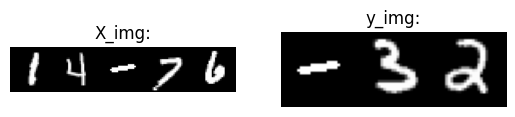

Query #6728

X_text: "33+64" = y_text: "97 "


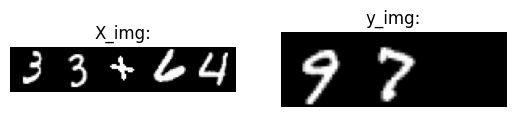

Query #353

X_text: "1-76 " = y_text: "-75"


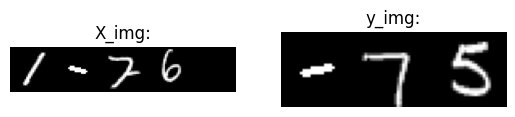

In [ ]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)

## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
        
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

 ## Helper functions



 The functions below will help with input/output of the data.

In [ ]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs

# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
    n = len(labels)
    length = len(labels[0])
    char_map = dict(zip(unique_characters, range(len(unique_characters))))
    one_hot = np.zeros([n, length, len(unique_characters)])
    
    for i, label in enumerate(labels):
        m = np.zeros([length, len(unique_characters)])
        for j, char in enumerate(label):
            m[j, char_map[char]] = 1
        one_hot[i] = m

    return one_hot

def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])
    
    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


 ---

 ## I. Text-to-text RNN model

 The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

 1. LSTM

 2. TimeDistributed

 3. RepeatVector

 The code cell below explains each of these new components.

 <img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [ ]:
def build_text2text_model():
    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. 
    # Each of these 5 elements in the query will be fed to the network one by one, as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. 
    # Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). 
    # This is necessary as TimeDistributed in the below expects the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

TRAIN, VALID, TEST Percentage 80.0 10.0 10.0
53+25
78 
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 256)               276480    
                                                                 
 repeat_vector_1 (RepeatVec  (None, 3, 256)            0         
 tor)                                                            
                                                                 
 lstm_4 (LSTM)               (None, 3, 256)            525312    
                                                                 
 time_distributed_6 (TimeDi  (None, 3, 13)             3341      
 stributed)                                                      
                                                                 
Total params: 805133 (3.07 MB)
Trainable params: 805133 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________________

2024-12-11 19:26:04.648579: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1733963167.693966   37554 service.cc:146] XLA service 0x7f053d98f510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733963167.694001   37554 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1733963167.694012   37554 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-12-11 19:26:07.712957: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733963168.012132   37554 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 [==============================] - 12s 11ms/step - loss: 1.7707 - accuracy: 0.3923 - val_loss: 1.4439 - val_accuracy: 0.4892
Epoch 2/50
500/500 [==============================] - 5s 9ms/step - loss: 1.3443 - accuracy: 0.5122 - val_loss: 1.2044 - val_accuracy: 0.5752
Epoch 3/50
500/500 [==============================] - 5s 9ms/step - loss: 1.1847 - accuracy: 0.5643 - val_loss: 1.1275 - val_accuracy: 0.5923
Epoch 4/50
500/500 [==============================] - 4s 9ms/step - loss: 1.0925 - accuracy: 0.5962 - val_loss: 1.1455 - val_accuracy: 0.5647
Epoch 5/50
500/500 [==============================] - 4s 9ms/step - loss: 1.0357 - accuracy: 0.6141 - val_loss: 1.0171 - val_accuracy: 0.6072
Epoch 6/50
500/500 [==============================] - 4s 9ms/step - loss: 0.9779 - accuracy: 0.6330 - val_loss: 0.9423 - val_accuracy: 0.6433
Epoch 7/50
500/500 [==============================] - 5s 9ms/step - loss: 0.9347 - accuracy: 0.6510 - val_loss: 0.9102 - val_accuracy: 0.6555
Epoch 8/50
500/

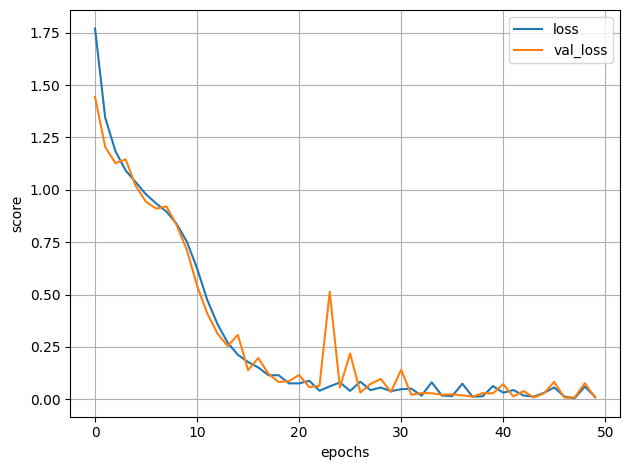

500/500 [==============================] - 2s 5ms/step - loss: 0.0046 - accuracy: 1.0000
Train Accuracy for text to text model: [0.004612775053828955, 0.9999791383743286]
63/63 [==============================] - 0s 5ms/step - loss: 0.0106 - accuracy: 0.9990
Test Accuracy for text to text model: [0.010592350736260414, 0.9990000128746033]
TRAIN, VALID, TEST Percentage 50.0 0.0 50.0
53+25
78 
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 256)               276480    
                                                                 
 repeat_vector_2 (RepeatVec  (None, 3, 256)            0         
 tor)                                                            
                                                                 
 lstm_6 (LSTM)               (None, 3, 256)            525312    
                                                         

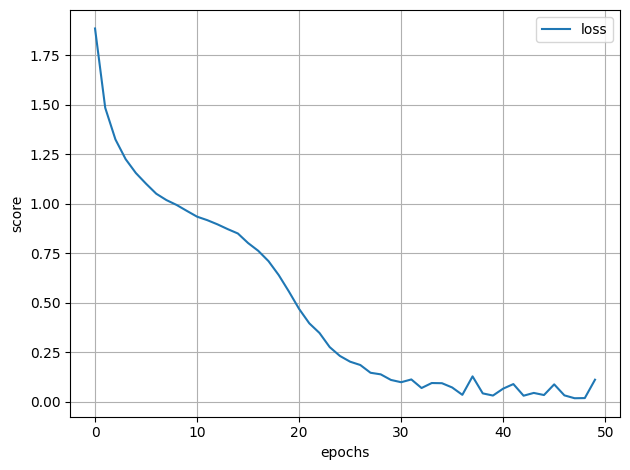

313/313 [==============================] - 2s 5ms/step - loss: 0.0313 - accuracy: 0.9943
Train Accuracy for text to text model: [0.031258244067430496, 0.9942666888237]
313/313 [==============================] - 1s 5ms/step - loss: 0.0541 - accuracy: 0.9843
Test Accuracy for text to text model: [0.05414434149861336, 0.984333336353302]
TRAIN, VALID, TEST Percentage 25.0 0.0 75.0
53+25
78 
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 256)               276480    
                                                                 
 repeat_vector_3 (RepeatVec  (None, 3, 256)            0         
 tor)                                                            
                                                                 
 lstm_8 (LSTM)               (None, 3, 256)            525312    
                                                            

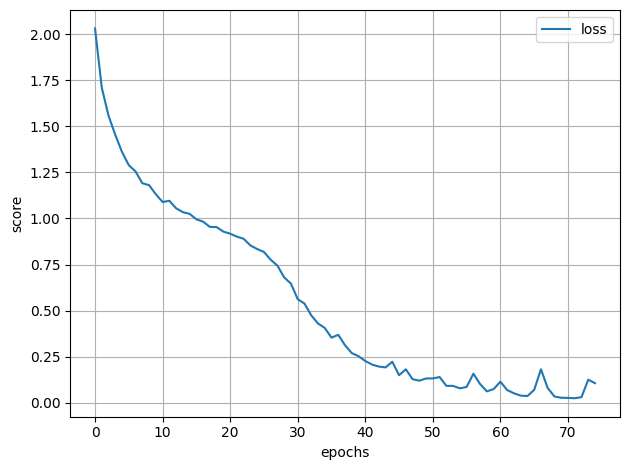

157/157 [==============================] - 1s 5ms/step - loss: 0.0358 - accuracy: 0.9963
Train Accuracy for text to text model: [0.035829149186611176, 0.9962666630744934]
469/469 [==============================] - 2s 5ms/step - loss: 0.1210 - accuracy: 0.9611
Test Accuracy for text to text model: [0.12103503197431564, 0.9611111283302307]
TRAIN, VALID, TEST Percentage 10.0 0.0 90.0
53+25
78 
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 256)               276480    
                                                                 
 repeat_vector_4 (RepeatVec  (None, 3, 256)            0         
 tor)                                                            
                                                                 
 lstm_10 (LSTM)              (None, 3, 256)            525312    
                                                        

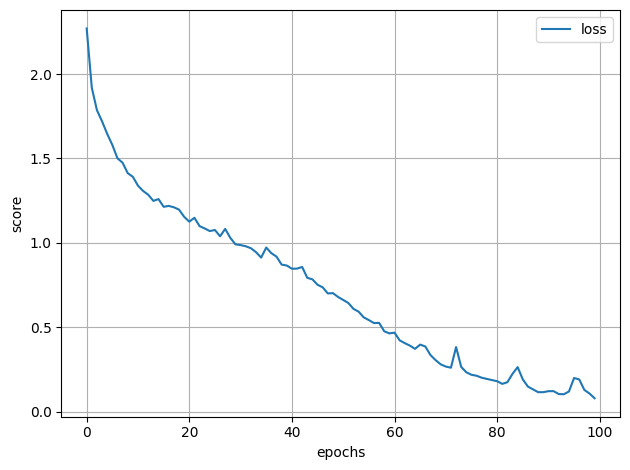

63/63 [==============================] - 1s 4ms/step - loss: 0.0644 - accuracy: 0.9965
Train Accuracy for text to text model: [0.06441336125135422, 0.9965000152587891]
563/563 [==============================] - 2s 4ms/step - loss: 0.8187 - accuracy: 0.7445
Test Accuracy for text to text model: [0.818695068359375, 0.744518518447876]


In [ ]:
## Your code (look at the assignment description for your tasks for text-to-text model):
##( Your first task is to fit the text2text model using X_text and y_text)
import tensorflow.keras as keras # type: ignore
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


data_percentage = [[80.0, 10.0, 10.0, 50], [50.0, 0.0, 50.0, 50], [25.0, 0.0, 75.0, 75], [10.0, 0.0, 90.0, 100]]

for each in data_percentage:
    print("TRAIN, VALID, TEST Percentage", each[0], each[1], each[2])
    X_train, X_test, y_train, y_test = train_test_split(X_text_onehot, y_text_onehot, 
                                                        test_size=(each[1]+each[2])/100.0, random_state=42) 

    
    print(decode_labels(X_test[0]))
    print(decode_labels(y_test[0]))
    # Fit the model
    model = build_text2text_model()
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
            f"text_to_text_best.keras", save_best_only=True
        )
    
    if each[1]:
        X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, 
                                                            test_size=each[1]/(each[1]+each[2]), random_state=42) 
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',  # metric to monitor
            patience=10,          # number of epochs to wait for improvement
            restore_best_weights=True  # restore the best weights after stopping
        )

        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_valid, y_valid),
            batch_size=32,
            epochs=50,
            callbacks=[checkpoint_cb, early_stopping],
        )
    else:
        history = model.fit(
            X_train,
            y_train,
            batch_size=32,
            epochs=each[-1],
            callbacks=[checkpoint_cb]
        )
    model.save(f'submission1_text_to_text.keras')

    data_history = pd.DataFrame(history.history)
    data_history.to_csv('text_to_text_history.csv')
    
    plt.plot(history.history['loss'], label='loss')
    if each[1]:
        plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('epochs')
    plt.ylabel('score')
    plt.legend(loc="best")

    plt.grid(True)
    plt.tight_layout()
    plt.show()

    predictions = model.predict(X_test)
    y_pred = [decode_labels(y) for y in predictions]
    y_actual = [decode_labels(y) for y in y_test]

    accuracy = accuracy_score(y_actual, y_pred)
    print("Train Accuracy for text to text model:", model.evaluate(X_train, y_train))
    print("Test Accuracy for text to text model:", model.evaluate(X_test, y_test))
    
    #to clear cache
    import gc

    # Delete unnecessary variables
    del model

    # Force garbage collection
    gc.collect()

 <div style="text-align: right">   </div>
 Introduction to Deep Learning (2024)

 **Assignment 2 - Sequence processing using RNNs**
 <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">

 # Introduction

 The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs).
 Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

 <img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

 In this assignment you will be working with three different kinds of models, based on input/output data modalities:

 1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation

 2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.

 3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.

 ### Description

 Let us suppose that we want to develop a neural network that learns how to add or subtract

 two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or

 ’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a

 sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,

 we want to build a model that generalizes well - if the network can extract the underlying principles behind

 the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate

 valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),

 2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.

 The example above describes a text-to-text sequence mapping scenario. However, we can also use different

 modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit

 dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

 *To work on this notebook you should create a copy of it.*


 # Function definitions for creating the datasets

 First we need to create our datasets that are going to be used for training our models.

 In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library.
 We will use these operand signs together with the MNIST dataset to represent the digits.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, LSTM, Flatten, TimeDistributed # type: ignore
from tensorflow.keras.layers import RepeatVector, Conv2D, ConvLSTM2D # type: ignore

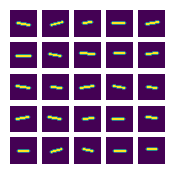

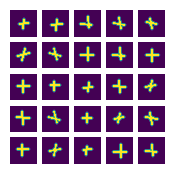

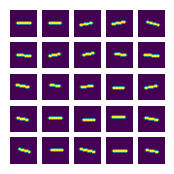

In [ ]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images


def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))
show_generated(generate_images(sign='-'))

In [ ]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:
    
    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=False)
                query_image = []

                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=False)
                result_image = []
                
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())
                    
                X_text.append(query_string)
                X_img.append(np.stack(query_image))

                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '

    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)

 # Creating our data

 The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

   **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]
   **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

   **y_text**: strings containing answers of length 3: ['  2', '156']
   **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #6997

X_text: "34-98" = y_text: "-64"


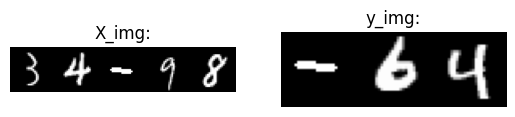

Query #7180

X_text: "35+90" = y_text: "125"


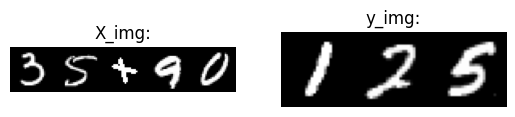

Query #9266

X_text: "46+33" = y_text: " 79"


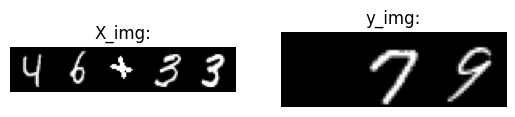

Query #1761

X_text: " 8-80" = y_text: "-72"


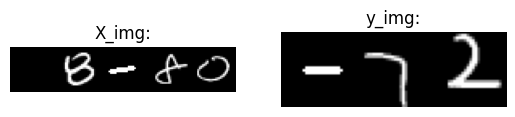

Query #2777

X_text: "13-88" = y_text: "-75"


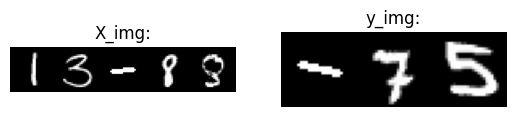

Query #5087

X_text: "25-43" = y_text: "-18"


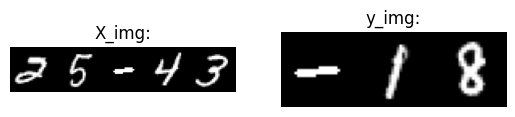

Query #4788

X_text: "23+94" = y_text: "117"


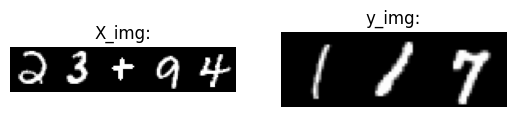

Query #93

X_text: " 0-46" = y_text: "-46"


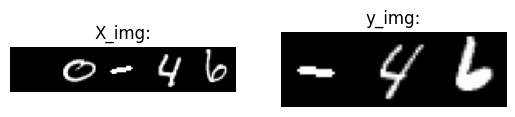

Query #5056

X_text: "25+28" = y_text: " 53"


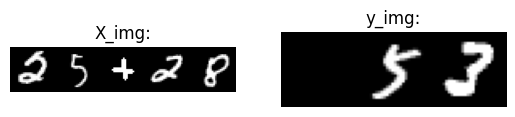

Query #3378

X_text: "16+89" = y_text: "105"


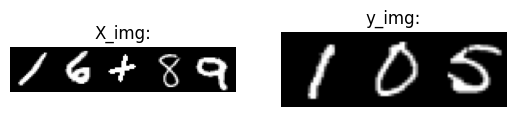

In [ ]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)

## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
        
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

 ## Helper functions



 The functions below will help with input/output of the data.

In [ ]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs

# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
    n = len(labels)
    length = len(labels[0])
    char_map = dict(zip(unique_characters, range(len(unique_characters))))
    one_hot = np.zeros([n, length, len(unique_characters)])
    
    for i, label in enumerate(labels):
        m = np.zeros([length, len(unique_characters)])
        for j, char in enumerate(label):
            m[j, char_map[char]] = 1
        one_hot[i] = m

    return one_hot

def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])
    
    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


 ---

 ## I. Text-to-text RNN model

 The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

 1. LSTM

 2. TimeDistributed

 3. RepeatVector

 The code cell below explains each of these new components.

 <img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [ ]:
def build_text2text_model():
    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. 
    # Each of these 5 elements in the query will be fed to the network one by one, as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. 
    # Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). 
    # This is necessary as TimeDistributed in the below expects the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

TRAIN, VALID, TEST Percentage 80.0 10.0 10.0
53+25
 78
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 256)               276480    
                                                                 
 repeat_vector_5 (RepeatVec  (None, 3, 256)            0         
 tor)                                                            
                                                                 
 lstm_12 (LSTM)              (None, 3, 256)            525312    
                                                                 
 time_distributed_10 (TimeD  (None, 3, 13)             3341      
 istributed)                                                     
                                                                 
Total params: 805133 (3.07 MB)
Trainable params: 805133 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________________

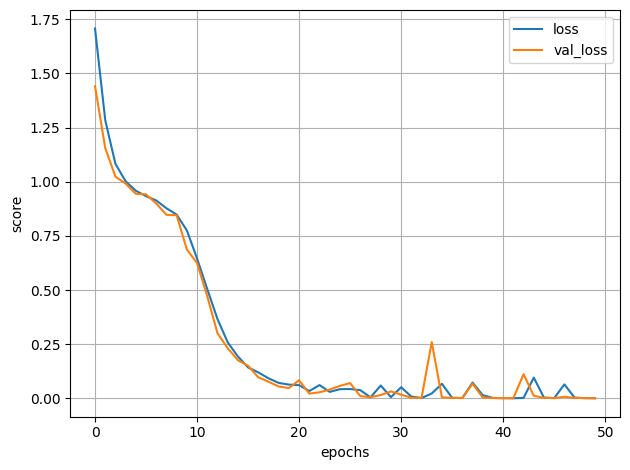

500/500 [==============================] - 3s 5ms/step - loss: 9.8690e-04 - accuracy: 1.0000
Train Accuracy for text to text model: [0.0009869028581306338, 1.0]
63/63 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 0.9998
Test Accuracy for text to text model: [0.0016546715050935745, 0.999833345413208]
TRAIN, VALID, TEST Percentage 50.0 0.0 50.0
53+25
 78
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 256)               276480    
                                                                 
 repeat_vector_6 (RepeatVec  (None, 3, 256)            0         
 tor)                                                            
                                                                 
 lstm_14 (LSTM)              (None, 3, 256)            525312    
                                                                 
 

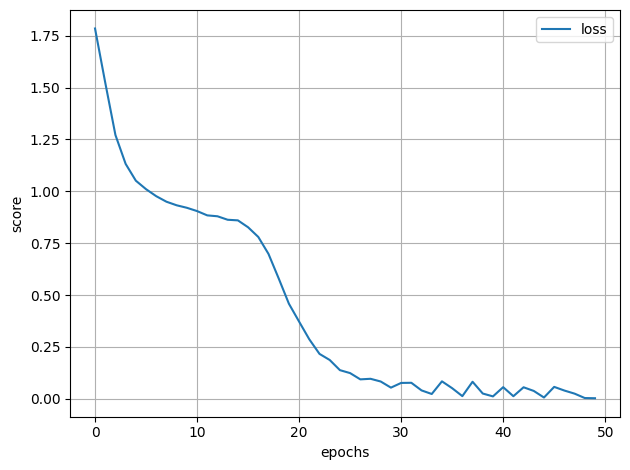

313/313 [==============================] - 2s 5ms/step - loss: 0.0021 - accuracy: 1.0000
Train Accuracy for text to text model: [0.0020791473798453808, 1.0]
313/313 [==============================] - 2s 5ms/step - loss: 0.0048 - accuracy: 0.9993
Test Accuracy for text to text model: [0.004848802927881479, 0.9992666840553284]
TRAIN, VALID, TEST Percentage 25.0 0.0 75.0
53+25
 78
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 256)               276480    
                                                                 
 repeat_vector_7 (RepeatVec  (None, 3, 256)            0         
 tor)                                                            
                                                                 
 lstm_16 (LSTM)              (None, 3, 256)            525312    
                                                                 
 ti

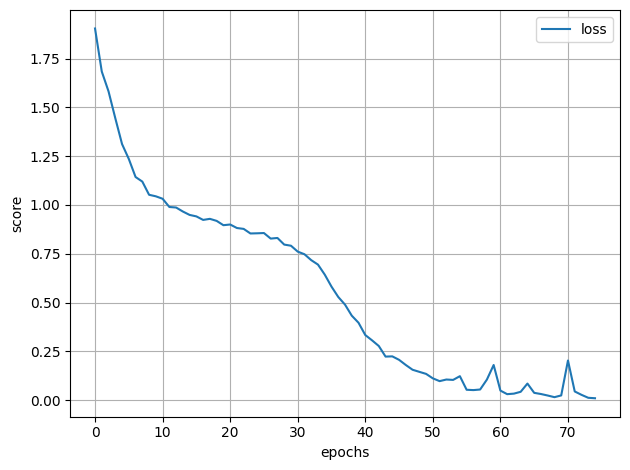

157/157 [==============================] - 2s 6ms/step - loss: 0.0067 - accuracy: 0.9999
Train Accuracy for text to text model: [0.006714425515383482, 0.9999333620071411]
469/469 [==============================] - 3s 6ms/step - loss: 0.0389 - accuracy: 0.9883
Test Accuracy for text to text model: [0.038914043456315994, 0.9883111119270325]
TRAIN, VALID, TEST Percentage 10.0 0.0 90.0
53+25
 78
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 256)               276480    
                                                                 
 repeat_vector_8 (RepeatVec  (None, 3, 256)            0         
 tor)                                                            
                                                                 
 lstm_18 (LSTM)              (None, 3, 256)            525312    
                                                       

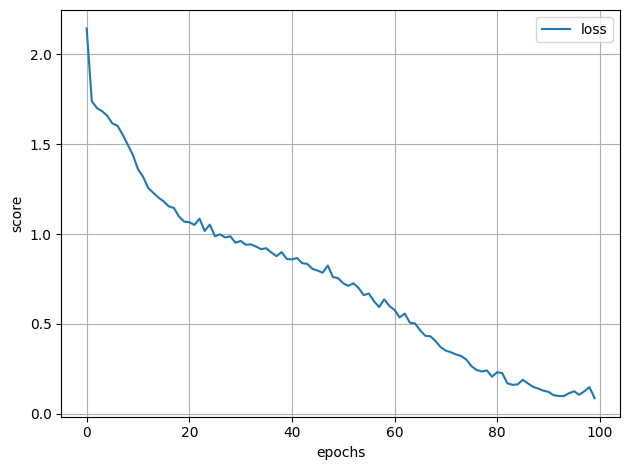

63/63 [==============================] - 1s 4ms/step - loss: 0.0687 - accuracy: 0.9917
Train Accuracy for text to text model: [0.06874980032444, 0.9916666746139526]
563/563 [==============================] - 3s 5ms/step - loss: 0.4698 - accuracy: 0.8386
Test Accuracy for text to text model: [0.46983692049980164, 0.8386296033859253]


In [ ]:
## Your code (look at the assignment description for your tasks for text-to-text model):
##( Your first task is to fit the text2text model using X_text and y_text)
import tensorflow.keras as keras # type: ignore
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


data_percentage = [[80.0, 10.0, 10.0, 50], [50.0, 0.0, 50.0, 50], [25.0, 0.0, 75.0, 75], [10.0, 0.0, 90.0, 100]]

for each in data_percentage:
    print("TRAIN, VALID, TEST Percentage", each[0], each[1], each[2])
    X_train, X_test, y_train, y_test = train_test_split(X_text_onehot, y_text_onehot, 
                                                        test_size=(each[1]+each[2])/100.0, random_state=42) 

    
    print(decode_labels(X_test[0]))
    print(decode_labels(y_test[0]))
    # Fit the model
    model = build_text2text_model()
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
            f"text_to_text_best.keras", save_best_only=True
        )
    
    if each[1]:
        X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, 
                                                            test_size=each[1]/(each[1]+each[2]), random_state=42) 
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',  # metric to monitor
            patience=10,          # number of epochs to wait for improvement
            restore_best_weights=True  # restore the best weights after stopping
        )

        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_valid, y_valid),
            batch_size=32,
            epochs=50,
            callbacks=[checkpoint_cb, early_stopping],
        )
    else:
        history = model.fit(
            X_train,
            y_train,
            batch_size=32,
            epochs=each[-1],
            callbacks=[checkpoint_cb]
        )
    model.save(f'submission1_text_to_text.keras')

    data_history = pd.DataFrame(history.history)
    data_history.to_csv('text_to_text_history.csv')
    
    plt.plot(history.history['loss'], label='loss')
    if each[1]:
        plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('epochs')
    plt.ylabel('score')
    plt.legend(loc="best")

    plt.grid(True)
    plt.tight_layout()
    plt.show()

    predictions = model.predict(X_test)
    y_pred = [decode_labels(y) for y in predictions]
    y_actual = [decode_labels(y) for y in y_test]

    accuracy = accuracy_score(y_actual, y_pred)
    print("Train Accuracy for text to text model:", model.evaluate(X_train, y_train))
    print("Test Accuracy for text to text model:", model.evaluate(X_test, y_test))
    
    #to clear cache
    import gc

    # Delete unnecessary variables
    del model

    # Force garbage collection
    gc.collect()